In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [10]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [11]:
sorted(b.items(), key=lambda kv: kv[1], reverse=True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [6]:
import torch

In [13]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [15]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1


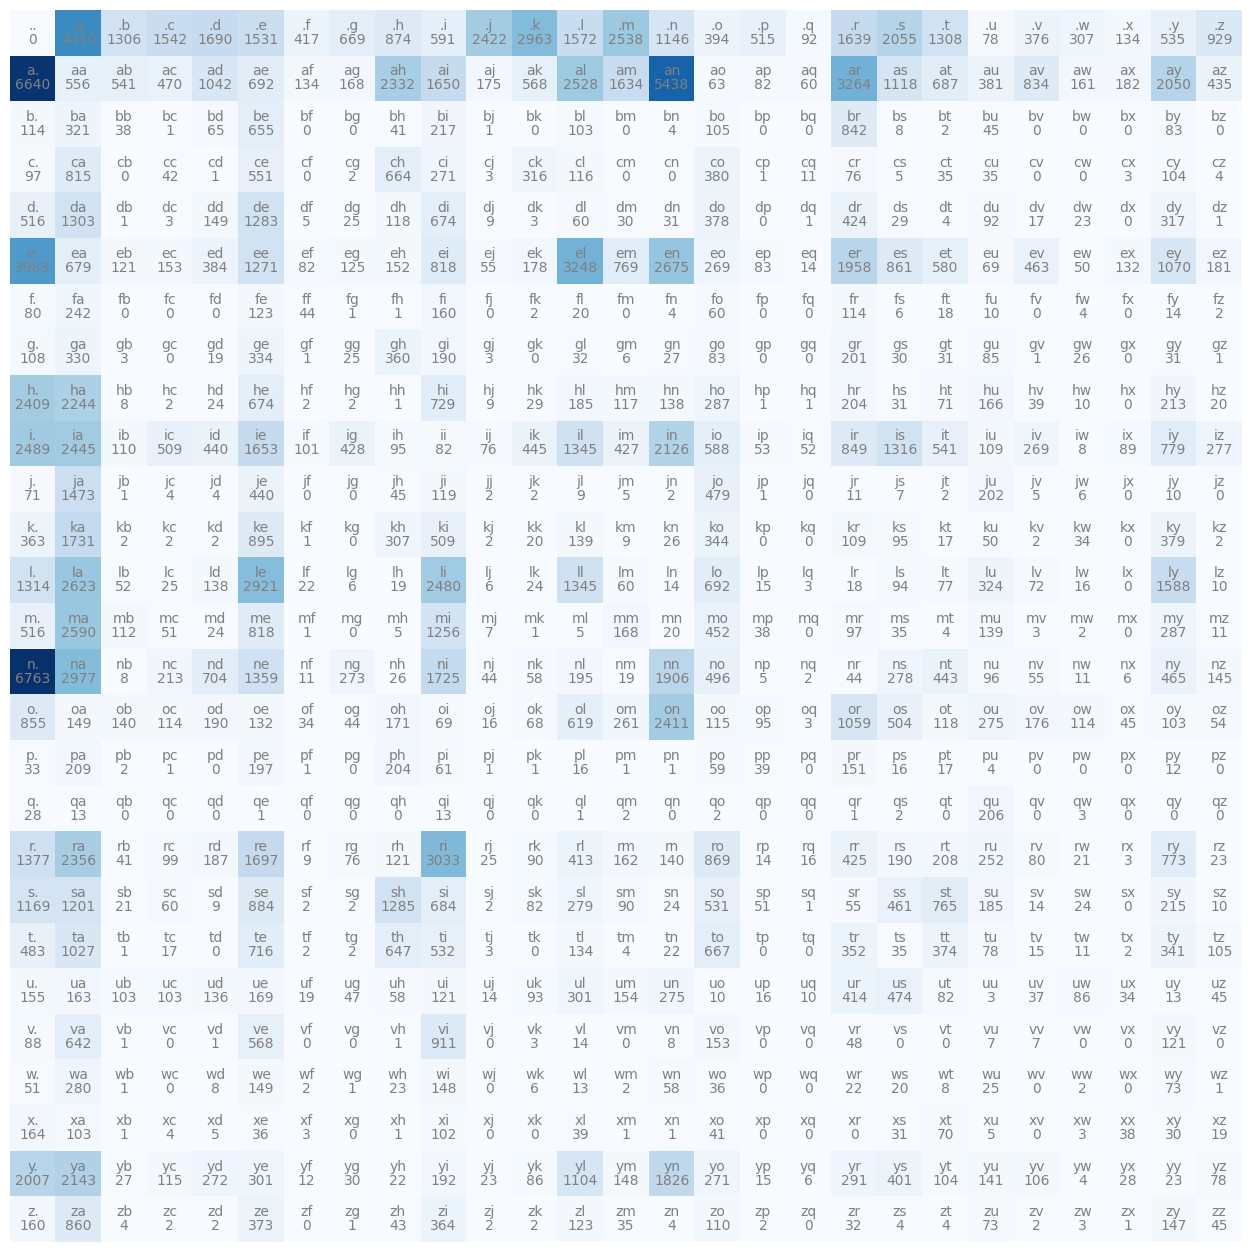

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [17]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [18]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [19]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [20]:
P = N.float()
P = P / P.sum(1, keepdim=True)
P[0].sum()

tensor(1.)

In [21]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


In [ ]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1
nll = -log_likelihood
print(f'{n} bigrams, log likelihood: {log_likelihood:.4f}, negative log likelihood: {nll:.4f}')
print(f'average log likelihood per bigram: {log_likelihood/n:.4f}')

228146 bigrams, log likelihood: -559891.7500, negative log likelihood: 559891.7500
average log likelihood per bigram: -2.4541


In [31]:
# create the training set of all the bigrams
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(f'{ch1}{ch2}: {ix1} {ix2}')
        xs.append(ix1)
        ys.append(ix2)   

xs = torch.tensor(xs)
ys = torch.tensor(ys)

.e: 0 5
em: 5 13
mm: 13 13
ma: 13 1
a.: 1 0


In [29]:
xs

tensor([ 0,  5, 13, 13,  1])

In [30]:
ys

tensor([ 5, 13, 13,  1,  0])

In [9]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()



In [41]:
xenc.shape

torch.Size([5, 27])

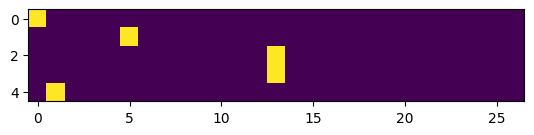

In [42]:
plt.imshow(xenc)

In [43]:
xenc.dtype

torch.float32

In [52]:
W = torch.randn((27,27))

In [57]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [58]:
probs[0]

tensor([0.0312, 0.0074, 0.0623, 0.0179, 0.0132, 0.0108, 0.0108, 0.0060, 0.0252,
        0.0350, 0.0321, 0.0053, 0.0393, 0.0120, 0.0044, 0.2400, 0.0583, 0.0033,
        0.1966, 0.0193, 0.0090, 0.0121, 0.0203, 0.0014, 0.0671, 0.0077, 0.0522])

In [ ]:
# SUMMARY ------------------------------>>>>

In [59]:
xs

tensor([ 0,  5, 13, 13,  1])

In [60]:
ys

tensor([ 5, 13, 13,  1,  0])

In [61]:
# randomly initialise 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [62]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [63]:
probs.shape

torch.Size([5, 27])

In [64]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286250479519367
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character:

In [ ]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [65]:
xs

tensor([ 0,  5, 13, 13,  1])

In [66]:
ys

tensor([ 5, 13, 13,  1,  0])

In [75]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [81]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [82]:
loss.item()

3.7492129802703857

In [77]:
# backward pass
W.grad = None
loss.backward()

In [78]:
W.data += -0.1 * W.grad

In [ ]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [71]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f'number of examples {num}')

# initialise the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples 228146


In [ ]:
# gradient descent
for k in range(100):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -50 * W.grad

3.758953094482422
3.371079444885254
3.1540327072143555
3.0203664302825928
2.9277069568634033
2.8604001998901367
2.809727191925049
2.7701010704040527
2.738072633743286
2.711496114730835
